# Data Mining / Prospecção de Dados 2022/2023

#### André Falcão DI/FCUL 2023


## Lab class TP11 - Clustering Graphs and Finding Communities


## 1. Creating Graphs and making simple representations

First let's get acquainted with darwing graphs using `graphviz`. Graphviz is a tricky library and many things can go wrong when installing it so all relevant figures are presented in the comments

So let's import this and other libraries

In [1]:
import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx

#conda install -c anaconda graphviz

First we will create a simple graph with 9 edges

In [2]:
def plot_graph(G, figsize=(6,6), node_size=500):
    f, ax = plt.subplots(1,1, figsize=figsize)
    display = display = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos=display, node_size = node_size, ax=ax)
    nx.draw_networkx_labels(G, pos=display, ax=ax)
    nx.draw_networkx_edges(G, pos=display, edgelist=G.edges, ax=ax, arrows=False)

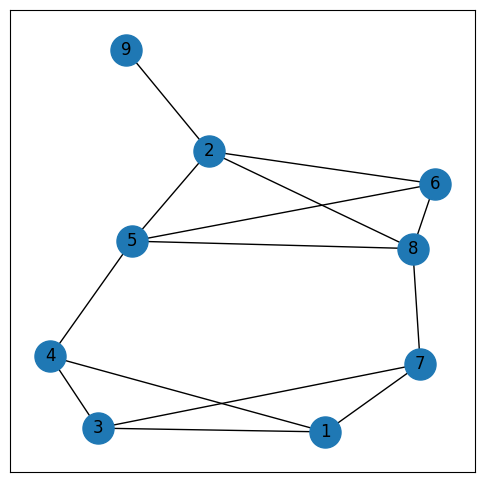

In [3]:

edges=[(1,3), (1,4), (3,4),
       (3,7), (4,5), (2,5),
       (2,6), (2,8), (5,6),
       (5,8), (8,6), (7,8), (1,7), (2,9)]

G = nx.Graph()
G.add_edges_from(edges)

plot_graph(G)

![Figure 1](fig_1.png)


### 1.1 Create the Adjacencies and the Laplacian of a Graph

Now let's create the adjaceny matrix from the set of nodes

In [4]:

def getGraphData(edges):
    Edges=np.array(edges)
    Nodes=np.unique(Edges)
    NN=Nodes.shape[0]

    A=np.zeros((NN,NN), dtype=int)
    for e in Edges: A[e[0]-1, e[1]-1]=1
    A+=A.T
    return Edges, Nodes, A

Edges, Nodes, A = getGraphData(edges)
print(A)

[[0 0 1 1 0 0 1 0 0]
 [0 0 0 0 1 1 0 1 1]
 [1 0 0 1 0 0 1 0 0]
 [1 0 1 0 1 0 0 0 0]
 [0 1 0 1 0 1 0 1 0]
 [0 1 0 0 1 0 0 1 0]
 [1 0 1 0 0 0 0 1 0]
 [0 1 0 0 1 1 1 0 0]
 [0 1 0 0 0 0 0 0 0]]


Whith this data we can make the Laplacian (L), which is just the Degree matrix (a matrix with the degree of all vertices in the corresponding diagonal element)

$$ L = D - A $$

In [5]:
def getLaplacian(A):
    D=np.diag(A.sum(axis=1))
    return D - A

L = getLaplacian(A)
#print(L)

## 2. Using Eigen structures for Spectral Graph Clustering

As we have seen, the usage of Eigen data constructed over the Laplacian is able to identify compact regions in graphs.

Let's visualise what is happening. First we will create the Eingenvalues and eigenvectors. It is clearly seen that these are not ordered

In [ ]:
evals, evecs=np.linalg.eig(L)
N=evals.shape[0]
print ("Eigenvalues")
print(np.around(evals, 3))
print ("Eigenvectors")
for i in range(N): print(np.around(evecs[:,i], 3))

In [ ]:
plt.bar(Nodes, evals)
plt.grid()
plt.show()

The Laplacian is a positive semi-definite matrix, meaning that some eigenvalues may be zero. The smallest eigenvalue corresponds to a constant value for all elements of the eigenvector

Let's get the ascending order of the eigenvalues 

In [ ]:
eord = np.argsort(evals)
print(eord)

let's plot the first and the 2nd eigenvalues

In [ ]:

L1=evecs[:,eord[0]]
plt.plot(Nodes, L1, ".--")
plt.grid()
plt.show()


In [ ]:
L2=evecs[:,eord[1]]
plt.plot(Nodes, L2, ".--")
plt.grid()
plt.show()


We can see in this last plot that the order of the of the points follows the order of the nodes in the graph. 

#### Exercise 

1. Verify that the zero line splits the graph in its most natural way
2. Identify the nodes above and below.
    * Above - 2,5,6,8,9
    * Below - 1,3,4,7
3. What is the most separate note? Can you understand why?

![Initial graph](fig_1.png)

We can have a different perspective if we display the points according to their order in the vector and verify that everything falls into place

In [6]:
def plotEigenVector(LL):
    NN=LL.shape[0]
    n_order=np.argsort(LL)
    plt.plot(np.arange(NN), LL[n_order], ".--")

    for x,y in zip(np.arange(NN), LL[n_order]):
        plt.annotate(Nodes[n_order[x]], (x,y), textcoords="offset points",
                     xytext=(0,3), ha='center', size=10)
    plt.grid()
    plt.show()
    
#plotEigenVector(L2)

#### Exercise
1. Check what happens when we do the same for the 3rd eigenvector. Comment your results

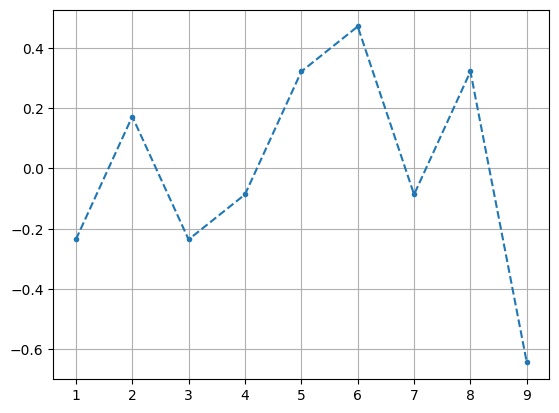

In [12]:
#solution
L3=evecs[:,eord[2]]
plt.plot(Nodes, L3, ".--")
plt.grid()
plt.show()

In [7]:
def plotEigenVectorWithOrder(LL, order):
    NN=LL.shape[0]
    n_order=np.argsort(order)
    plt.plot(np.arange(NN), LL[n_order], ".--")

    for x,y in zip(np.arange(NN), LL[n_order]):
        plt.annotate(Nodes[n_order[x]], (x,y), textcoords="offset points",
                     xytext=(0,3), ha='center', size=10)
    plt.grid()
    plt.show()
    
plotEigenVectorWithOrder(L3, L2)

NameError: name 'L3' is not defined

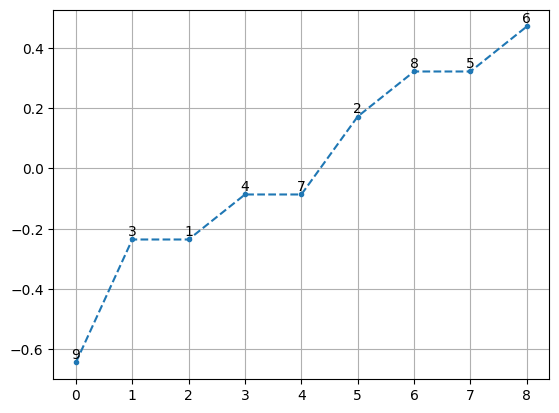

In [14]:
plotEigenVector(L3)

Using the 2nd Eigenvector or separation we can have a better view of the graph.

Note that we do not need to use zero as a separation criterion. Any other value will produce different results

In [8]:
def GraphEdgeSplitter(Nodes, edges, L2, threshold=0.0):
    
    nodes_cluster_1=set(Nodes[L2>=threshold])
    nodes_cluster_2=set(Nodes[L2< threshold])

    inner_edges_1=[]
    inner_edges_2=[]
    between_edges=[]
    for i, j in edges:
        if   i in nodes_cluster_1 and j in nodes_cluster_1: inner_edges_1.append((i,j))
        elif i in nodes_cluster_2 and j in nodes_cluster_2: inner_edges_2.append((i,j))
        else: between_edges.append((i,j))
    return inner_edges_1, inner_edges_2, between_edges
        
def plotClusteredGraph(edges_1, edges_2, edges_b):
    g = graphviz.Graph('G')
    g.engine="fdp"
    with g.subgraph(name="cluster_inside1") as sg1:
        sg1.attr(label="Cluster 1")
        for i,j in edges_1: sg1.edge(str(i), str(j))

    with g.subgraph(name="cluster_inside2") as sg2:
        sg2.attr(label="Cluster 2")
        for i,j in edges_2: sg2.edge(str(i), str(j))

    for i,j in edges_b: g.edge(str(i), str(j))
    return g

e1, e2, eb = GraphEdgeSplitter(Nodes, edges, L2)
G=plotClusteredGraph(e1, e2, eb)
#G.format="png"
#G.render("fig_2")
#G

NameError: name 'L2' is not defined

Using -0.1 as a threshold cut

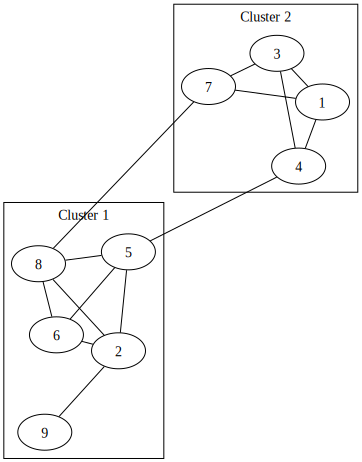

In [16]:
e1, e2, eb = GraphEdgeSplitter(Nodes, edges, L2, threshold=-0.1 )
G = plotClusteredGraph(e1, e2, eb)
G.format="png"
G.render("fig_3")
G

### 1.3. A more complex example

Let's try it with one of the first social netwoeks analized, the karate network that has 34 nodes

In [17]:

lines=open("soc-karate.data", "rt").readlines()
edges=[line.split() for line in lines]
edges=[(int(i),int(j)) for i, j in edges]

Edges, Nodes, A = getGraphData(edges)
L=getLaplacian(A)


And let's visualise it

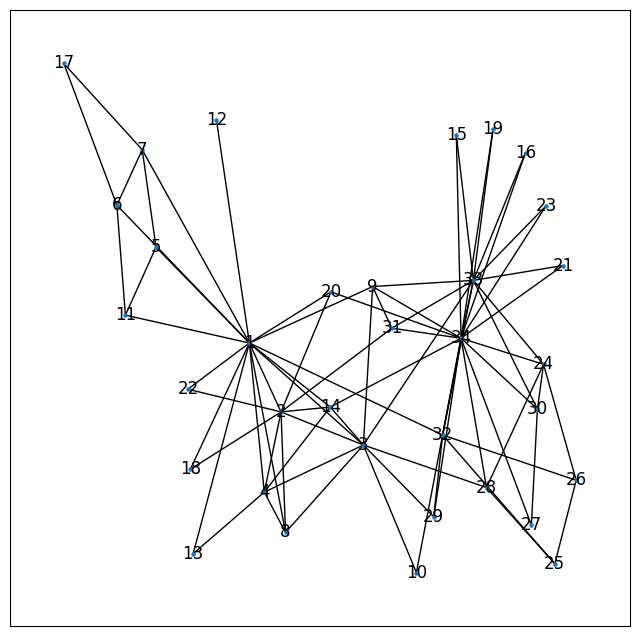

In [18]:
G = nx.Graph()
G.add_edges_from(edges)
plot_graph(G, figsize=(8,8), node_size=5)

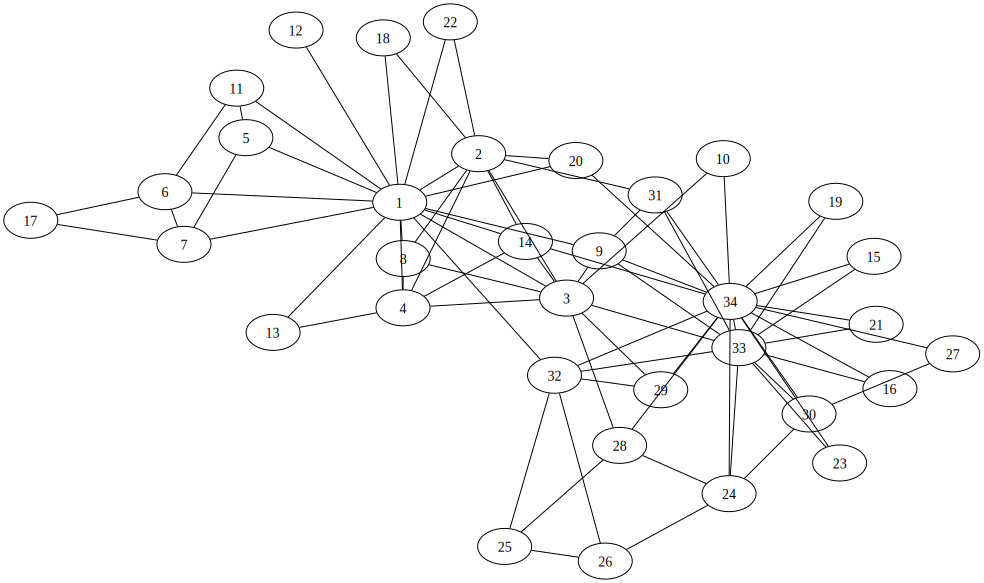

In [19]:
G = graphviz.Graph()
G.engine="fdp"
for i,j in edges: G.edge(str(i),str(j))

G.format="png"
G.render("fig_1")
G

#### Exercises 

1. Try to cluster the new graph with the methods above
    1. First identify the required steps then put them to work and plot the final result
2. Identify if you can identify other thresholds for more meaningful clustering

In [20]:
#order of the procedure
# --> Adj + Lap
# --> EigenStruc
# --> λ_2
# --> plot λ_2
# --> cut

In [21]:
#implementation
evals, evecs=np.linalg.eig(L)
N=evals.shape[0]
eord = np.argsort(evals)

In [22]:
L2 = L[:, eord[1]]

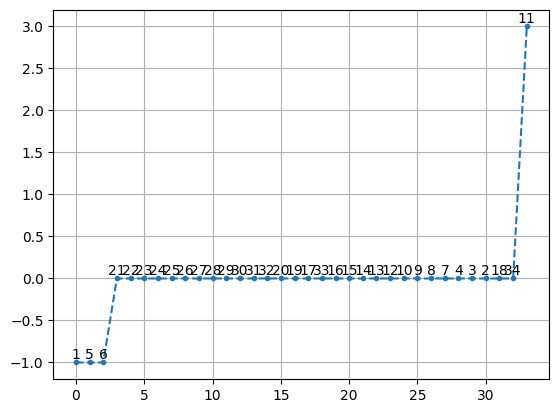

In [23]:
plotEigenVector(L2)

### 1.4. Using KMeans or other common methods for graph clustering

As L2 and L3 are complementary we we can use them as projections of the graph into a new space and use the new vector coordinates to make clustering

We will use KMeans clustering for a new dataset (even though the current SKLearn seems hopelessly broken)

This new dataset has evidently 3 different communities

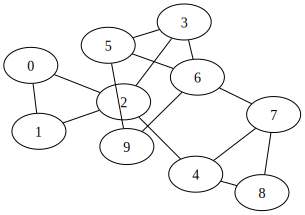

In [9]:
edges=[(1,2), (1,3), (2,3),
       (3,4), (3,5), (4,6),
       (4,7), (6,7), (5,8), (5,9),
       (6,10), (7,10), (7,8), (8,9)]

edges=[(i-1, j-1) for i,j in edges]
Edges, Nodes, A = getGraphData(edges)
L=getLaplacian(A)

G = graphviz.Graph()
G.engine="fdp"
for i,j in edges: G.edge(str(i),str(j))
G.format="png"
G.render("fig_6")
G


In [ ]:
G = nx.Graph()
G.add_edges_from(edges)
plot_graph(G)

#### Exercise

1. Check with the above methods if you can identify the different clusters for this example

In [10]:
#solution
Edges, Nodes, A = getGraphData(edges)


In [27]:
L = getLaplacian(A)
evals, evecs=np.linalg.eig(L)
eord = np.argsort(evals)

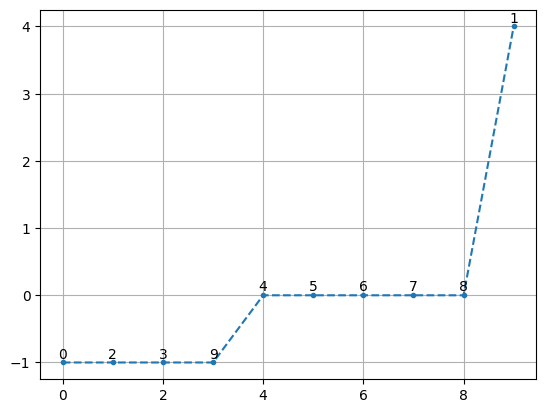

In [28]:
plotEigenVector(L[:, eord[1]])

The usage of Kmeans is strightforward as soon as the eingenvalues are computed

In [29]:
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

#Get 2nd and 3rd eigenvalues
eord = np.argsort(evals)
L2=evecs[:,eord[1]]
L3=evecs[:,eord[2]]

#make X matrix
X=np.stack((L2, L3)).T

#do the kmeans
k=3
kms=KMeans(k)
kms=kms.fit(X)

for i in range(k):
    print("Nodes in Cluster", i, "-->", Nodes[kms.labels_==i])


Nodes in Cluster 0 --> [0 1 9]
Nodes in Cluster 1 --> [2 4 5 8]
Nodes in Cluster 2 --> [3 6 7]


In [30]:
kms.labels_

array([0, 0, 1, 2, 1, 1, 2, 2, 1, 0])

As this is in 2D we can plot the nodes in their new coordinate space

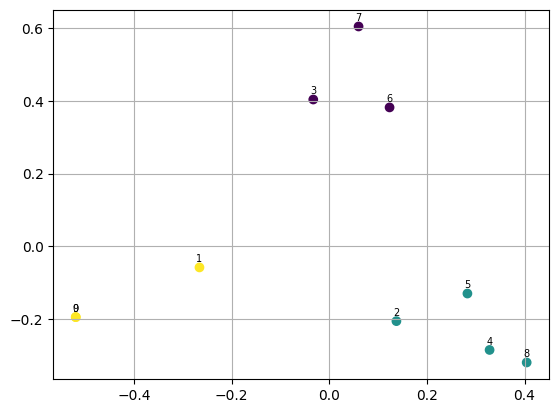

In [637]:
plt.scatter(X[:,0], X[:,1], c=kms.labels_)
for i,(x,y) in enumerate(X):
    plt.annotate(i, (x,y), textcoords="offset points", xytext=(0,4), ha='center', size=7)
plt.grid()
plt.show()

## 2. Identifying communities



As we have seen we may want to define directly a coomunity by attributing probabilities of each node of belonging to it. Obviously a node can belong to more than one community

we have found that we can compute the probability of two nodes being connected if they belong to a community by this expression, where $F_u$ is a factor that defines the force of a node belonging to that community

$$ P(u,v) = 1- exp(-F_u.F_v^T) $$

As we actually know thse nodes are connected (as all the other elements of the graph!), we can use this knowledge to estimate compute the best set of Fs that maximizes the likelihood of this actual graph is constructed

$$ argmax_F = \prod_{(u,v) \in E} {p(u,v)} \prod_{(u,v) \notin E} {(1- p(u,v))} $$

We can compute the log-likelihood which is actually easier to handle computationally

$$ argmax_F L(F)= \sum_{(u,v) \in E} {log(1-exp(-F_u.F_v^T))} - \sum_{(u,v) \notin E} {F_u.F_v^T} $$

This is is an actual evaluation function that for a set of weights $F_u$ is able to compute a score of the likelihood that the actual graph is produced

Let's set up a random estimation for Fs

As per the formula we are going to noeed the connections and the no-connections of each node

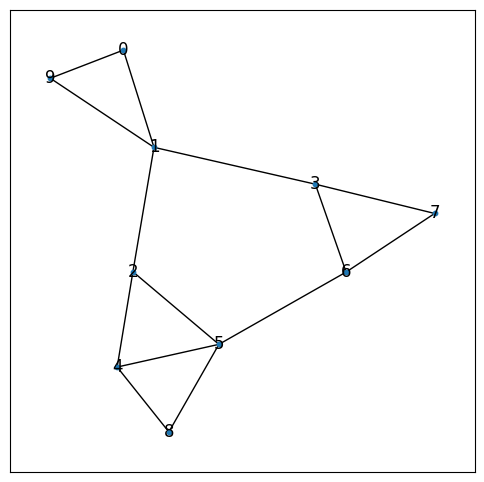

In [11]:
#lines=open("soc-karate.data", "rt").readlines()
#edges=[line.split() for line in lines]
#edges=[(int(i)-1,int(j)-1) for i, j in edges]

Edges, Nodes, A = getGraphData(edges)

g=nx.Graph()
g.add_edges_from( np.argwhere(A!=0) )
plot_graph(g, node_size=10)

In [12]:
from tqdm.notebook import tqdm

In [33]:
np.unique(kms.labels_, return_counts=True)

(array([0, 1, 2]), array([3, 4, 3], dtype=int64))

In [13]:
def getConnections(edges, Nodes):
    NN=Nodes.shape[0]
    conns={}
    nconns={}
    for i,j in edges: 
        conns.setdefault(i, set()).add(j)
        conns.setdefault(j, set()).add(i)
    all_nodes = set(list(range(NN)))
    nconns = {}
    for i in Nodes: 
        nconns[i] = list(all_nodes - conns[i]-{i})
        conns[i] = list(conns[i])
    return conns, nconns

conns, nconns = getConnections(np.argwhere(A!=0), Nodes)

Now we can have our evaluation function of a given F matrix, wat is the likelihood of a given node $u$


In [14]:
def evalFactor(u, F, conns, nconns):
    NN, k=F.shape
    res=0 
    for v in conns[u]: res += np.log(1-np.exp(-F[u].dot(F[v]))) 
    res -=  F[nconns[u],:].dot(F[u]).sum()
    return res

Now let's create a simple stochastic hill climbing approach that will change randomly each row of the F matrix accepting this new solution if it actually is better that what was there before

In [15]:
def SHC(conns, nconns, F, LR=0.001, niters=1000):
    NN, k = F.shape
    res_best=[evalFactor(u, F, conns, nconns) for u in range(NN)]
    LR=0.01
    for i in tqdm(range(niters)):
        for u in range(NN):
            chg=np.random.random(k)*LR- LR/2
            F_old = F[u].copy()
            F[u] += chg
            F[u]=np.clip(F[u], 0, 1)
            res = evalFactor(u, F, conns, nconns)
            if res>=res_best[u]:
                res_best[u]=res
            else:
                F[u] = F_old
    res_best=[evalFactor(u, F, conns, nconns) for u in range(NN)]
    return F, sum(res_best)

In [16]:
def get_graph_from_communities(F):
    N, k = F.shape
    graph = np.zeros((N,N))
    
    for i in range(N):
        for j in range(N):
            if i!=j:
                graph[i,j] = F[i]@F[j]
    
    return graph

In [ ]:
def get_affiliation_from_communities(F, δ):
    pass

In [17]:
NN=Nodes.shape[0]
k=3
F = np.zeros((NN,k)) + 1/5

res=[evalFactor(u, F, conns, nconns) for u in range(NN)]
print("Initial Evaluation: ", sum(res))

Initial Evaluation:  -68.47058102914188


In [18]:
F, LL =SHC(conns, nconns, F, niters=5000)

#print(np.around(_, 3))
print("Final Evaluation: ", LL)

  0%|          | 0/5000 [00:00<?, ?it/s]

Final Evaluation:  -33.904265098211546


In [19]:
temp = (get_graph_from_communities(F))#>0.1 )*1
print(np.round(temp , 2))

[[0.   0.75 0.   0.69 0.   0.   0.3  0.43 0.   0.56]
 [0.75 0.   0.38 0.92 0.28 0.41 0.54 0.57 0.   0.74]
 [0.   0.38 0.   0.07 1.09 1.35 0.48 0.   0.55 0.  ]
 [0.69 0.92 0.07 0.   0.12 0.12 0.41 0.52 0.11 0.68]
 [0.   0.28 1.09 0.12 0.   1.58 0.57 0.   1.   0.  ]
 [0.   0.41 1.35 0.12 1.58 0.   0.67 0.   1.   0.  ]
 [0.3  0.54 0.48 0.41 0.57 0.67 0.   0.23 0.38 0.3 ]
 [0.43 0.57 0.   0.52 0.   0.   0.23 0.   0.   0.42]
 [0.   0.   0.55 0.11 1.   1.   0.38 0.   0.   0.  ]
 [0.56 0.74 0.   0.68 0.   0.   0.3  0.42 0.   0.  ]]


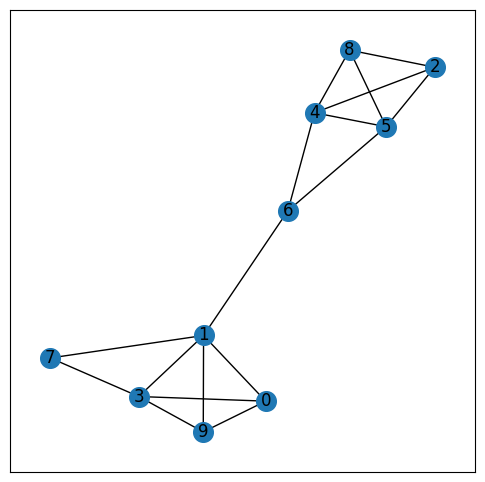

In [20]:
g = nx.Graph()
g.add_edges_from(np.argwhere((temp>0.5)*1!=0))
plot_graph(g, node_size=200)

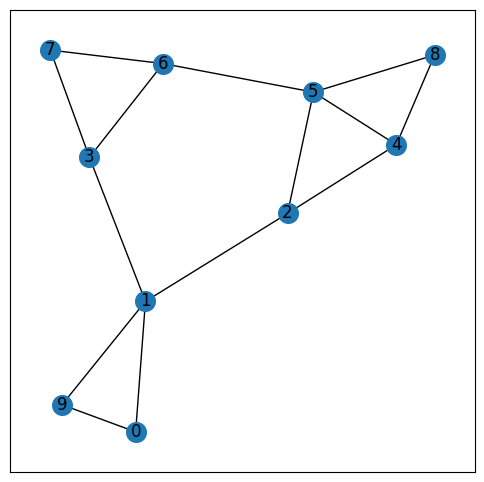

In [56]:
g = nx.Graph()
g.add_edges_from(np.argwhere(A!=0))
plot_graph(g, node_size=200)

In [31]:
c = get_communities(F, 0.8)
list(map(len, c.values()))

[3, 2, 2]

In [22]:
def prob(x):
    return 1 - np.exp(-x)

In [23]:
def rand(shape, min=0, max=1):
    return np.random.rand(*shape) *(max - min + 1) + min

In [24]:
def get_F(shape, min_=0, max_=1, α=1e-8):
    """
    Generates a random F matrix with a E-community that connects all nodes with a weight { α }
    """
    
    F = rand(shape, min_, max_)
    F = np.concatenate( (F, np.full( (shape[0], 1), α) ), axis=1)
    return F

In [25]:
def loss_func(u, F, conns, nconns):    
    fv_conns = F[conns[u]]
    fv_nconns = F[nconns[u]]
    fu = F[u].reshape(1,-1)
     
    prob_conns = prob( fu@fv_conns.T)
    conns_sum = np.log(prob_conns).sum()
    
    nconns_sum = (fu@fv_nconns.T).sum()
    return conns_sum - nconns_sum

In [26]:
def log_likelihood(fu, f_sum, fv_conns):
    prob_conns = prob( fu@fv_conns.T)
    conns_sum = np.log(prob_conns).sum()
    
    fv_nconns = f_sum - fu - fv_conns.sum(axis=0)
    nconns_sum = (fu * fv_nconns).sum()
    return conns_sum - nconns_sum

In [27]:
def big_clam(conns, nconns, F, LR=0.001, n_iters=1000, MAX_FVALUE=1):
    NN, k = F.shape
    
    F_gradients=np.zeros(F.shape)    
    for i in tqdm(range(n_iters)): 
        f_sum = F.sum(axis=0)
        
        for u in range(NN):
            #F vectors of nodes connected to u
            fv_conns = F[conns[u]]
            #F vector of node u
            fu = F[u]
            
            #connection probablity of fu to each fv
            prob_con = prob(fu@fv_conns.T)
            
            fraction = (1 - prob_con)/prob_con
            conns_factor = (fv_conns.T @ fraction)
            
            #optimization of non-connection neighbours sum
            nconns_factor = f_sum - fu - fv_conns.sum(axis=0)
            
            u_grad = conns_factor - nconns_factor
            F_gradients[u] = LR*(n_iters-i)/n_iters * u_grad
            
            #log_likelihood(fu, f_sum, fv_conns)
            #F[u, :-1] = np.clip(F[u, :-1] + LR*(n_iters - i)/n_iters * u_grad[:-1], 0, MAX_FVALUE)
            
        F[:, :-1] = np.clip(F[:, :-1] + F_gradients[:, :-1], 0, MAX_FVALUE)
        
    res_best=[-log_likelihood(F[u], F.sum(axis=0), F[conns[u]]) for u in range(NN)]
    return F, sum(res_best)

In [28]:
def get_communities(F, thresh):
    NN, k = F.shape
    
    comunities = {}
    for c in range(k):
        locs = np.where(F[:, c]>=thresh)[0]
        comunities[c] = set(list(locs))
    return comunities

In [59]:
F = get_F((NN, k))
#F = np.concatenate( (np.full((NN,k), 1/3), np.full((NN,1), 1e-8)), axis=1) 
res=[-loss_func(u, F, conns, nconns) for u in range(F.shape[0])]
print("Initial Evaluation: ", sum(res))

Initial Evaluation:  210.73109680685263


In [67]:
F, ll = big_clam(conns, nconns, F, n_iters=10000, LR=0.001, MAX_FVALUE=None)
print("Final Evaluation: ", ll)

  0%|          | 0/10000 [00:00<?, ?it/s]

Final Evaluation:  8.51884064000373


In [65]:
ϵ = 1e-8
δ = np.sqrt( 1 - np.log(1 - ϵ))

In [68]:
np.round(F, 2)

array([[1.14, 0.  , 0.  , 0.  ],
       [5.18, 0.  , 0.  , 0.  ],
       [0.22, 0.  , 0.68, 0.  ],
       [0.22, 1.44, 0.  , 0.  ],
       [0.  , 0.  , 3.6 , 0.  ],
       [0.  , 0.22, 3.58, 0.  ],
       [0.  , 4.14, 0.  , 0.  ],
       [0.  , 1.44, 0.  , 0.  ],
       [0.  , 0.  , 0.68, 0.  ],
       [1.14, 0.  , 0.  , 0.  ]])

In [69]:
temp = (get_graph_from_communities(F))#>0.1 )*1
print(np.round(temp , 2))

[[ 0.    5.93  0.25  0.25  0.    0.    0.    0.    0.    1.31]
 [ 5.93  0.    1.12  1.12  0.    0.    0.    0.    0.    5.93]
 [ 0.25  1.12  0.    0.05  2.46  2.45  0.    0.    0.47  0.25]
 [ 0.25  1.12  0.05  0.    0.    0.31  5.97  2.08  0.    0.25]
 [ 0.    0.    2.46  0.    0.   12.89  0.    0.    2.46  0.  ]
 [ 0.    0.    2.45  0.31 12.89  0.    0.89  0.31  2.45  0.  ]
 [ 0.    0.    0.    5.97  0.    0.89  0.    5.98  0.    0.  ]
 [ 0.    0.    0.    2.08  0.    0.31  5.98  0.    0.    0.  ]
 [ 0.    0.    0.47  0.    2.46  2.45  0.    0.    0.    0.  ]
 [ 1.31  5.93  0.25  0.25  0.    0.    0.    0.    0.    0.  ]]


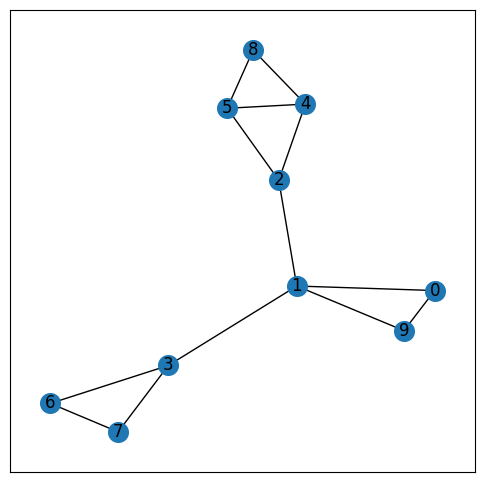

In [70]:
g = nx.Graph()
g.add_edges_from(np.argwhere((temp>δ)*1!=0))
plot_graph(g, node_size=200)

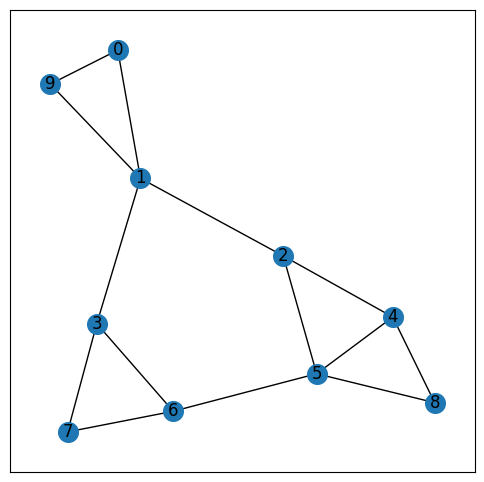

In [54]:
g = nx.Graph()
g.add_edges_from( np.argwhere(A!=0))
plot_graph(g, node_size=200)

In [96]:
def matrix_factorization(matrix,Itertions,learning_rate):
    fact_mat = matrix
    lr = learning_rate
    I = Itertions
    all_fu_change = []
    for iter in tqdm(range(0,I)):   # Taking max i as 500
        if iter < I or all([q>0.001 for q in all_fu_change]): # Checking if i<I or percentage change of fu for all fu <0.001%
            all_fu_change = []
      #print(iter)
            fw=[0]*(k+1)
            for w in fact_mat:
                fw = np.add(fw,w) # Finidnf sigma fw term
            
            for i in range(0,NN): # For each node
                fu = fact_mat[i,] # fu value
                neig = conns[i] # Getting the list of neigbors
                fv_neig=[0]*(k+1)
                first_term = [0]*(k+1)
        
                for j in neig:
                    fv_neig=np.add(fv_neig, fact_mat[j]) # Adding all neighbor nodes
                    try:
                        term = fact_mat[j]*(
                            math.exp(
                                -(np.dot(fu,fact_mat[j]))
                            )/(1-math.exp(
                                -(np.dot(fu,fact_mat[j]))
                            ))) # first term in gradient equation
                    except: #ZeroDivisionError:
                        print("zero")
                        print(np.dot(fu, fact_mat[j]))
                        return
                        term = 0 #fact_mat[int(j)]*(math.exp(-(np.dot(fu,fact_mat[int(j)]))))
                    #print(term)
                    first_term = np.add(first_term,term) # Adding all the first terms
                
                fv_not_neig = np.subtract(np.subtract(fw,fu),fv_neig) # fc not neighbors value calulatio
                grad_fu = np.subtract(first_term,fv_not_neig) # Finiding the fradient
                fu[:-1] = fu[:-1] + (grad_fu[:-1]*lr) # updating fu
                before = np.sum(fact_mat[i,]) # getting the prev values of fu
                
                for y in range(0,k):
                    if fu[y]< 0:
                        fact_mat[i,y] = 0 # projecting fu values to if the update value is neagtive
                    else:
                        fact_mat[i,y] = fu[y]      # if positving, assiging the new values
        
                after = np.sum(fact_mat[i,]) # getting the updated value of fu
                fu_change = ((after - before)/before)*100  # calculating the percentage change
                all_fu_change.append(fu_change)
    return fact_mat

In [95]:
import math

In [97]:
F = get_F((NN, k))
#F = np.concatenate( (np.full((NN,k), 1/3), np.full((NN,1), 1e-8)), axis=1) 
res=[-loss_func(u, F, conns, nconns) for u in range(F.shape[0])]
print("Initial Evaluation: ", sum(res))

Initial Evaluation:  127.1972659428042


In [98]:
F = matrix_factorization(F, 10000, 0.001)
sum([-loss_func(u, F, conns, nconns) for u in range(F.shape[0])])

  0%|          | 0/10000 [00:00<?, ?it/s]

8.412001641916289

In [99]:
np.round(F,2)

array([[0.  , 1.15, 0.  , 0.  ],
       [0.  , 5.39, 0.  , 0.  ],
       [0.  , 0.21, 0.68, 0.  ],
       [1.45, 0.21, 0.  , 0.  ],
       [0.  , 0.  , 3.64, 0.  ],
       [0.21, 0.  , 3.62, 0.  ],
       [4.14, 0.  , 0.  , 0.  ],
       [1.44, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.68, 0.  ],
       [0.  , 1.15, 0.  , 0.  ]])

In [81]:
all(a>1 for a in [])

True

In [790]:
from sklearn.metrics.cluster import normalized_mutual_info_score, v_measure_score

In [83]:
ϵ = 10**-8
ϵ

1e-08

In [107]:
idx=3
F.sum() - F[idx].sum() - F[conns[idx]].sum()

6.0059999999999985

In [108]:
F[nconns[idx]].sum()

6.006

In [110]:
δ = np.sqrt(-np.log(1- ϵ))
1 - np.exp(-δ)

9.999500066781852e-05

In [90]:
F[nconns[0]].shape

(7, 3)

#### Exercises
1. Examine the results above and comment them comparing them to the original graph
2. Change the initalization and the learning parameters to try to get better results